# Filter for pairwise retrosynthesizability

## Aim of this notebook

This notebook is filtering the fragments for pairwise retrosynthesizability using the web API from [ASKCOS](https://askcos.mit.edu/).

We build all valid fragment pairs and look if a retrosynthetic route can be found to create this pair from the fragments given. To reduce the number of requests we, first apply all filters from the previous notebooks.

## Table of contents
1. Load fragment library
2. Apply filters
    
    2.1. Apply pre-filters
    
    2.2. Apply filters for unwanted substructures
    
        2.2.1. PAINS filter
        
        2.2.2 Brenk filter
    
    2.3. Apply filters for drug likeness
        
        2.3.1. Rule of Three filter
        
        2.3.2. Quantitative Estimate of Druglikeness filter
        
    2.4. Apply filters for synthesizability
    
        2.4.1. Filter for buyable building blocks
        
        2.4.2. Filter for Synthetic Bayesian Estimation
        
    2.5. Process filtering results
        
        2.5.1. Check which fragments pass all filters applied
        
        2.5.2. Save the values computed by each filtering step
    
    2.6. Remove fragments not passing the previous filtering steps
    
3. Apply pairwise retrosynthesizability

    3.1. Get valid fragment pairs
    
    3.2. Calculate pairwise retrosynthesizability
    
4. Analyze accepted/ rejected fragments

    4.1. Count number of accepted/rejected fragments
    
    4.2. Plot number of retrosynthetic routes found per fragment and subpocket
    
    4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found
    
    4.4 Save custom filtered fragment library
    
        4.4.1. Add results from pairwise retrosynthesizability to the filtering results
        
        4.4.2. Save fragment_library_custom_filtered to data

## Imports and preprocessing

In [1]:
import warnings
import pandas as pd
from pathlib import Path
from rdkit.Chem import PandasTools
from IPython.core.display import HTML
from kinfraglib import filters, utils

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Needed to display ROMol images in DataFrames
PandasTools.RenderImagesInAllDataFrames(images=True)

### Define global paths

In [4]:
# Path to data
HERE = Path().resolve()
PATH_DATA = HERE / "../../data"
PATH_DATA_BRENK = PATH_DATA / "filters/Brenk"
PATH_DATA_ENAMINE = HERE / "../../data/filters/Enamine"
PATH_DATA_RETRO = HERE / "../../data/filters/retrosynthesizability"
PATH_DATA_CUSTOM = PATH_DATA / "fragment_library_custom_filtered"

## 1. Load fragment library

In [5]:
fragment_library = utils.read_fragment_library(PATH_DATA / "fragment_library")

In [6]:
fragment_library.keys()

dict_keys(['AP', 'FP', 'SE', 'GA', 'B1', 'B2', 'X'])

In [7]:
pd.concat(fragment_library).reset_index(drop=True).shape

(7486, 15)

## 2. Apply filters

    2.2. Apply filters for unwanted substructures
    
        2.2.1. PAINS filter
        
        2.2.2 Brenk filter
    
    2.3. Apply filters for drug likeness
        
        2.3.1. Rule of Three filter
        
        2.3.2. Qunatitative Estimate of Druglikeness filter
        
    2.4. Apply filters for synthesizability
    
        2.4.1. Filter for buyable building blocks
        
        2.4.2. Filter for Synthetic Bayesian Estimation
        
    2.5. Process filtering results
        
        2.5.1. Check which fragments pass all filters applied
        
        2.5.2. Save the values computed by each filtering step
    
    2.6. Remove fragments not passing the previous filtering steps

These filters are applied to reduce the number of fragments before building pairs for the pairwise retrosynthesizability filter to avoid the combinatorial explosion and enable this analysis.

### 2.1. Apply pre-filters
Pre-filters are 
- removing fragments in pool X
- removing duplicates
- removing fragments without dummy atoms (unfragmented ligands)
- removing fragments only connecting to pool X

In [8]:
fragment_library = filters.prefilters.pre_filters(fragment_library)

### 2.2. Apply filters for unwanted substructures
Filter out fragments that could cause unwanted side effects.

For more information, check [/notebooks/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_1_custom_filters_unwanted_substructures.ipynb)

#### 2.2.1. PAINS filter
Remove fragments that can appear as false positive hits in HTS assays.

[ J. Med. Chem. 2010, 53, 7, 2719–2740](https://pubs.acs.org/doi/abs/10.1021/jm901137j)

In [9]:
fragment_library, _ = filters.unwanted_substructures.get_pains(fragment_library)

#### 2.2.2 Brenk filter
Remove fragments containing substructures which do not enrich libraries for lead like compounds, defined by Brenk et al. ([ChemMedChem, 2008, 3(3),435--444](https://chemistry-europe.onlinelibrary.wiley.com/doi/full/10.1002/cmdc.200700139)).

In [10]:
fragment_library, brenk_structs = filters.unwanted_substructures.get_brenk(
    fragment_library, PATH_DATA_BRENK
)

Number of unwanted substructures in Brenk et al. collection: 104


### 2.3. Apply filters for drug likeness
For more information, check [/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_2_custom_filters_drug_likeness.ipynb)

#### 2.3.1. Rule of Three filter
Filter the fragments according to the Rule of Three ([Drug Discovery Today, 2003, 8(19):876-877](https://www.sciencedirect.com/science/article/abs/pii/S1359644603028319?via%3Dihub)).

In [11]:
fragment_library = filters.drug_likeness.get_ro3_frags(fragment_library)

####  2.3.2. Quantitative Estimate of Druglikeness filter
The Quantitative Estimate of Druglikeness reflects the molecular properties ([Nat Chem. 2012 Jan 24; 4(2): 90–98](https://www.nature.com/articles/nchem.1243)).

In [12]:
fragment_library = filters.drug_likeness.get_qed(fragment_library, cutoff_val=0.492)

### 2.4. Apply filters for synthesizability

For more information, check [/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb](https://github.com/sonjaleo/KinFragLib/blob/custom-base/notebooks/custom_kinfraglib/1_3_custom_filters_synthesizability.ipynb)

#### 2.4.1. Filter for buyable building blocks
Building blocks can be used to synthesize molecules on demand.

**Note**: A description to the generation of the `"/filters/DataWarrior/Enamine_Building_Blocks.sdf"` file used in this function can be found in the [README](https://github.com/sonjaleo/KinFragLib/blob/review-update/data/filters/DataWarrior/README.md) file in the `"data/filters/DataWarrior"` directory.

In [13]:
fragment_library = filters.synthesizability.check_building_blocks(
    fragment_library,
    str(str(PATH_DATA_ENAMINE) + "/Enamine_Building_Blocks.sdf"),
)

Number of building blocks: 1562


#### 2.4.2. Filter for Synthetic Bayesian Estimation
The Synthetic Bayesian Estimation is a fragment based estimate, determining whether a molecule is easy or hard to synthesize.

[(J Cheminform 12, 35 (2020))](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-020-00439-2) 

In [14]:
fragment_library = filters.synthesizability.calc_syba(fragment_library, cutoff=0)

### 2.5. Process filtering results
* 2.5.1. Check which fragments pass all filters applied
* 2.5.2. Save the values computed by each filtering step

#### 2.5.1. Check which fragments pass all filters applied

Check which fragments pass all filters applied.

In [15]:
fragment_library = filters.analysis.number_of_accepted(
    fragment_library, columns=[
        "bool_pains",
        "bool_brenk",
        "bool_ro3",
        "bool_qed",
        "bool_bb",
        "bool_syba",
    ],
    min_accepted=6)
pd.concat(fragment_library).reset_index(drop=True).shape

(2859, 27)

Count number of fragments pre-filtered and accepted by all filters, or not accepted by at least one filter.

In [16]:
num_fragments_filter = pd.concat([filters.analysis.count_fragments(
    fragment_library,
    "pre_filtered"),
           filters.analysis.count_accepted_rejected(
              fragment_library,
              "bool", "filtered")],
          axis=1)
num_fragments_filter = pd.concat([num_fragments_filter, num_fragments_filter.sum().rename("Total").to_frame().T])
num_fragments_filter
# NBVAL_CHECK_OUTPUT

,pre_filtered,accepted_filtered,rejected_filtered
AP,1001,233,768
FP,862,174,688
SE,606,165,441
GA,306,100,206
B1,42,9,33
B2,42,18,24
Total,2859,699,2160


#### 2.5.2. Save the values computed by each filtering step

Save filtering results for analysis to [/data/filters/fragment_library_custom_filtered/custom_filter_results.csv](https://github.com/sonjaleo/KinFragLib/blob/fragment_pairs/data/fragment_library_custom_filtered/custom_filter_results.csv).

In [17]:
columns = [
    "bool_pains",
    "bool_brenk",
    "bool_ro3",
    "bool_qed",
    "qed",
    "bool_bb",
    "bool_syba",
    "syba",
]
filters.retro.save_filter_results(fragment_library, columns, PATH_DATA_CUSTOM)

### 2.6. Remove fragments not passing the previous filtering steps

We are removing the fragments not passing the previours filtering steps, namely
* PAINS filter
* Brenk filter
* Rule of Three filter
* QED filter
* Building Block filter
* SYBA filter

to reduce the number of fragments used in building fragment pairs to avoid the combinatorial explosion and enable the use of the pairwise retrosynthesizability.

In [18]:
for subpocket in fragment_library.keys():
    fragment_library[subpocket].drop(
        fragment_library[subpocket].loc[fragment_library[subpocket]['bool'] == 0].index,
        inplace=True,
    )
    fragment_library[subpocket] = fragment_library[subpocket].reset_index(drop=True)
pd.concat(fragment_library).reset_index(drop=True).shape

(699, 27)

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,0.565900,1,1,30.950959,1
1,AP,CNc1ncnc2[nH]ccc12,,,,ACK,Ack,TK,4ewh,T77,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 5 5 8 8 8 na ...,[26*]c1[nH]c2ncnc(NC[54*])c2c1[37*],8,"[FP, SE, FP]","[AP=FP, AP=SE, AP=FP]",1,1,1,1,0.633912,1,1,38.386371,1
2,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,A,B,AP AP AP AP AP AP AP AP AP AP AP AP SE GA,16 16 16 16 16 16 16 16 16 16 16 16 na na,[33*]c1cnc2c([46*])cnn2c1,10,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,0.511376,1,1,39.622898,1
3,AP,Nc1cc(C2CC2)[nH]n1,,,,ACTR2,STKR,TKL,3soc,GVD,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,15 15 15 15 15 15 15 15 14 14 14 14 14 14 14 5...,[17*]Nc1cc(C2CC2)[nH]n1,5,[SE],[AP=SE],1,1,1,1,0.581756,1,1,18.524861,1
4,AP,Clc1c[nH]c2ncncc12,,,,AKT1,Akt,AGC,3cqw,CQW,A,A,AP AP AP AP AP AP AP AP AP AP AP AP AP FP,14 14 14 14 14 14 14 14 14 14 14 14 14 na,[17*]c1ncnc2[nH]cc(Cl)c12,1,[FP],[AP=FP],1,1,1,1,0.624952,1,1,18.136369,1

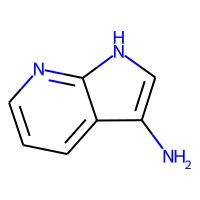
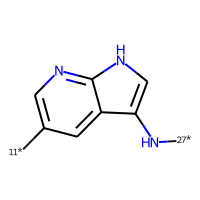
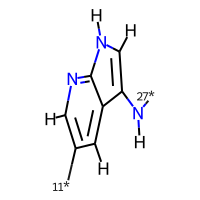
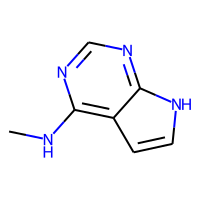
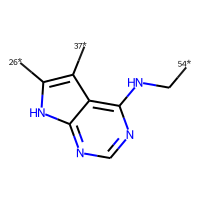
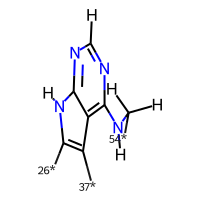
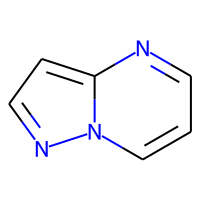
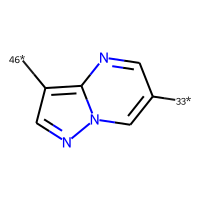
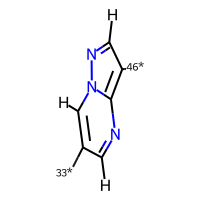
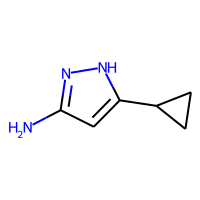
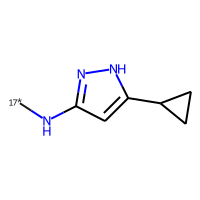
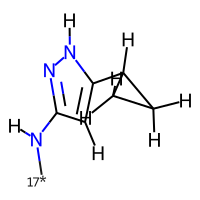
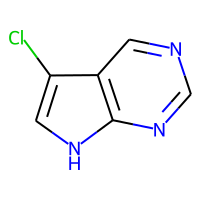
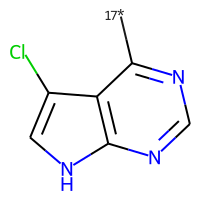
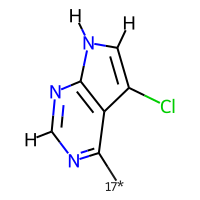

In [19]:
HTML(fragment_library["AP"].head().to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

## 3. Apply pairwise retrosynthesizability

    3.1. Get valid fragment pairs
    
    3.2. Calculate pairwise retrosynthesizability

### 3.1. Get valid fragment pairs
First we need to get all valid fragment pairs, meaning fragments which have adjacent subpockets, the same bond type and matching BRICS [(J. Chem. Inf. Model. 2017, 57, 4, 627–631)](https://doi.org/10.1021/acs.jcim.6b00596) environment types.

In [20]:
?filters.retro.get_valid_fragment_pairs

Signature: filters.retro.get_valid_fragment_pairs(fragment_library)
Docstring:
Gets all possible fragment pairs and validates if their bond type, BRICS environment type
and adjacent subpockets are matching. Then it creates the SMILES string from the combined
pairs.

Parameters
----------
fragment_libray : dict
    fragments organized in subpockets including all information

Returns
-------
DataFrame
    SMILES from valid paired fragments.
File:      ~/KinFragLib/kinfraglib/filters/retro.py
Type:      function

Note: this function might take a few minutes

In [21]:
valid_fragment_pairs, unique_pairs = filters.retro.get_valid_fragment_pairs(fragment_library)

Number of fragments:  699
Number of unique pairs: 39976


Note: valid_fragment_pairs contains also the duplicated pairs like [AP_0, SE_0] and [SE_0, AP_0]

### 3.2. Calculate pairwise retrosynthesizability
ASKCOS is used to check if for the fragment pairs a retrosynthetic route can be found. We will exclude all fragments without at least one retrosynthetic route found.

For each fragment pair, we will start an ASKCOS query, requesting if ASKCOS can find a one step retrosynthetic route building this fragment pair. For all routes found, we will retrieve the children building the requested fragment pair and also the plausibility of this reaction.
Afterwards, we will compare the children retrieved from ASKCOS with the fragments building the pair. If the fragments are substructures of the children their `retro_count` is increased by one and the fragments, pair, children and plausibility are stored in the `mol_df` dataframe. If they are no substructures, we will store the information in the `diff_df` dataframe.

[ASKCOS webpage for One-step Retrosynthesis](https://askcos.mit.edu/retro/)

ASKCOS query is started for fragment pairs which were not already requested (already requested fragment pairs can be found in [/data/filters/retrosynthesizability/retro.txt](https://github.com/sonjaleo/KinFragLib/blob/fragment_pairs/data/filters/retrosynthesizability/retro.txt)) and children retrieved from ASKCOS get compared with the fragments building the pairs.
Depending on the number of new queries and molecule comparisons this could run a long time (a query of 1000 fragment pairs takes about 1h 30min on an 8 core machine).

Note: If your internet connection is instable, you might need to run this several times. When starting it again it will only compute the pairs which were not yet computed.

In [22]:
%%time
warnings.filterwarnings("ignore")
fragment_library, mol_df, diff_df = filters.retro.get_pairwise_retrosynthesizability(
    unique_pairs,
    PATH_DATA_RETRO,
    valid_fragment_pairs,
    fragment_library,
)

ASKCOS query started for 0 fragments.
ASKCOS query finished.
Comparing ASKCOS children with fragments..
Checking if all fragment pairs were requested..
All fragment pairs were requested.
Done.
CPU times: user 8min 5s, sys: 2.08 s, total: 8min 7s
Wall time: 9min


Note: if not all fragment pairs were requested, please run this function again.

Inspect individual subpockets, including the new column if at least one retrosynthetic route was found or not per fragment (`bool_retro`) and number of retrosynthetic routes found (`retro_count`). 

,subpocket,smiles,ROMol,ROMol_dummy,ROMol_original,kinase,family,group,complex_pdb,ligand_pdb,alt,chain,atom_subpockets,atom_environments,smiles_dummy,fragment_count,connections,connections_name,bool_pains,bool_brenk,bool_ro3,bool_qed,qed,bool_bb,bool_syba,syba,bool,retro_count,bool_retro
0,AP,Nc1c[nH]c2ncccc12,,,,AAK1,NAK,Other,5l4q,LKB,B,A,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP F...,16 16 16 16 16 16 16 16 16 16 16 16 16 5 5 na na,[11*]c1cnc2[nH]cc(N[27*])c2c1,3,"[FP, SE]","[AP=FP, AP=SE]",1,1,1,1,0.565900,1,1,30.950959,1,0,0
1,AP,CNc1ncnc2[nH]ccc12,,,,ACK,Ack,TK,4ewh,T77,,B,AP AP AP AP AP AP AP AP AP AP AP AP AP AP AP A...,16 16 16 16 16 16 16 16 16 16 16 5 5 8 8 8 na ...,[26*]c1[nH]c2ncnc(NC[54*])c2c1[37*],8,"[FP, SE, FP]","[AP=FP, AP=SE, AP=FP]",1,1,1,1,0.633912,1,1,38.386371,1,0,0
2,AP,c1cnc2ccnn2c1,,,,ACTR2,STKR,TKL,3q4t,TAK,A,B,AP AP AP AP AP AP AP AP AP AP AP AP SE GA,16 16 16 16 16 16 16 16 16 16 16 16 na na,[33*]c1cnc2c([46*])cnn2c1,10,"[SE, GA]","[AP=SE, AP=GA]",1,1,1,1,0.511376,1,1,39.622898,1,152,1

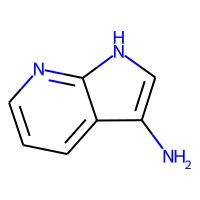
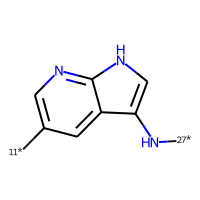
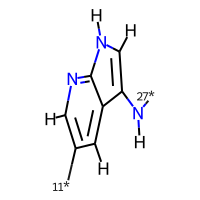
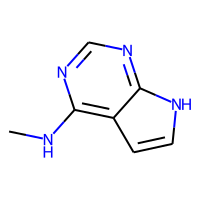
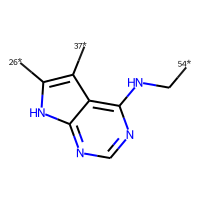
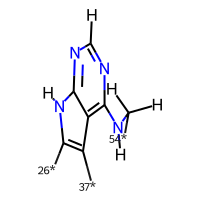
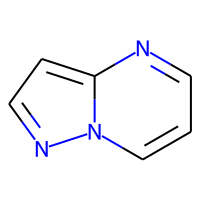
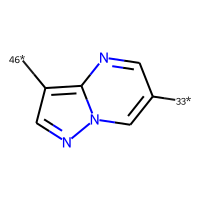
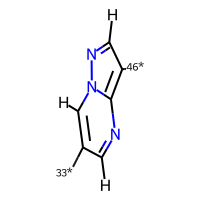

In [23]:
HTML(fragment_library["AP"].head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

In [24]:
HTML(mol_df.to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

In [ ]:
HTML(diff_df.head(3).to_html(notebook=True))
# NBVAL_CHECK_OUTPUT

## 4. Analyze accepted/ rejected fragments

    4.1. Count number of accepted/rejected fragments
    
    4.2. Plot number of retrosynthetic routes found per fragment and subpocket
    
    4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found
    
    4.4 Save custom filtered fragment library
    
        4.4.1. Add results from pairwise retrosynthesizability to the filtering results
        
        4.4.2. Save fragment_library_custom_filtered to data

### 4.1. Count number of accepted/rejected fragments

In [ ]:
num_fragments_retro = pd.concat(
    [
        filters.analysis.count_fragments(
            fragment_library, "custom_filtered"
        ),
        filters.analysis.count_accepted_rejected(
            fragment_library, "bool_retro", "pairwise_retosynthesizability"
        ),
    ],
    axis=1,
)
num_fragments_retro = pd.concat([num_fragments_retro, num_fragments_retro.sum().rename("Total").to_frame().T])
num_fragments_retro
# NBVAL_CHECK_OUTPUT

### 4.2. Plot number of retrosynthetic routes found per fragment and subpocket

In [ ]:
filters.plots.make_retro_hists(fragment_library, "retro_count", cutoff=0)

legend: red bars display the number fragments without a retrosynthetic route found

### 4.3. Inspect fragments with no retrosynthetic routes found and with most retrosynthetic routes found

#### Adenine Pocket (AP)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="AP",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="AP",
    molsPerRow=10,
)

#### Front Pocket (FP)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="FP",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="FP",
    molsPerRow=10,
)

#### Solvent Exposed Pocket (SE)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="SE",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="SE",
    molsPerRow=10,
)

#### Gate Area Pocket (GA)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="GA",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="GA",
    molsPerRow=10,
)

#### Back Pocket 1 (B1)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="B1",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="B1",
    molsPerRow=10,
)

#### Back Pocket 2 (B2)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="none",
    subpocket="B2",
    molsPerRow=10,
)

In [ ]:
filters.plots.retro_routes_fragments(
    fragment_library,
    evaluate="max",
    subpocket="B2",
    molsPerRow=10,
)

### 4.4 Save custom filtered fragment library

#### 4.4.1. Add results from pairwise retrosynthesizability to the filtering results

Load previous filtering results and values from [/data/filters/fragment_library_custom_filtered/custom_filter_results.csv](https://github.com/sonjaleo/KinFragLib/blob/fragment_pairs/data/fragment_library_custom_filtered/custom_filter_results.csv) file and add retro results to this file.

In [ ]:
saved_filter_results = pd.read_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv")

In [ ]:
saved_filter_results.set_index(["subpocket", "smiles"])

In [ ]:
fragment_library_concat = pd.concat(fragment_library)
retro_results_df = pd.DataFrame()
retro_results_df["subpocket"] = fragment_library_concat["subpocket"]
retro_results_df["smiles"] = fragment_library_concat["smiles"]
retro_results_df["retro_count"] = fragment_library_concat["retro_count"]
retro_results_df["bool_retro"] = fragment_library_concat["bool_retro"]
retro_results_df.set_index(["subpocket", "smiles"])

In [ ]:
all_results_df = saved_filter_results.merge(
    retro_results_df,
    left_on=['subpocket', 'smiles'],
    right_on=['subpocket', 'smiles'],
    how="outer",
)
all_results_df.to_csv(PATH_DATA_CUSTOM / "custom_filter_results.csv", index=False)

#### 4.4.2. Save fragment_library_custom_filtered to data

Save custom filtered fragment library as .sdf files to [/data/filters/fragment_library_custom_filtered/](https://github.com/sonjaleo/KinFragLib/blob/fragment_pairs/data/fragment_library_custom_filtered/)

In [ ]:
for subpocket in fragment_library.keys():
    fragment_library[subpocket].drop(
        fragment_library[subpocket].loc[fragment_library[subpocket]["bool_retro"] == 0].index,
        inplace=True,
    )
    fragment_library[subpocket] = fragment_library[subpocket].reset_index(drop=True)

In [ ]:
fragment_library_concat = pd.concat(fragment_library)
fragment_library_concat.head()

In [ ]:
filters.retro.save_fragment_library_to_sdfs(
    PATH_DATA_CUSTOM,
    fragment_library_concat,
)